# Predicting US Census Income Category with Apache Spark

## CLASSIFICATION

Write the description here.

In [1]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
from pyspark.sql.functions import round, col
import pyspark.sql.functions as F

from pyspark.ml.classification import LogisticRegression

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel

from pyspark.ml.feature import StringIndexer, OneHotEncoder, StandardScaler, VectorAssembler

from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4
#plt.style.use('seaborn-whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 4

In [5]:
# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

## 1. Understanding the Data Set

## 2. Creating the Spark Session

In [6]:
os.environ['SPARK_HOME']

'D:\\Work\\spark-2.3.0-bin-hadoop2.7'

In [7]:
spark = SparkSession.builder.master("local[2]").appName("predict-us-census-income").getOrCreate()
spark

In [8]:
sc = spark.sparkContext
sc

<SparkContext master=local[2] appName=predict-us-census-income>

In [9]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

## 3. Load The Data From a File Into a Dataframe

In [10]:
ADULT_TRAIN_DATA = 'data/adult-training.csv'
ADULT_TEST_DATA = 'data/adult-test.csv'

In [11]:
# define the schema, corresponding to a line in the csv data file.
schema = StructType([
    StructField("age", IntegerType(), nullable=True),
    StructField("workclass", StringType(), nullable=True),
    StructField("fnlgwt", DoubleType(), nullable=True),
    StructField("education", StringType(), nullable=True),
    StructField("education_num", DoubleType(), nullable=True),
    StructField("marital_status", StringType(), nullable=True),
    StructField("occupation", StringType(), nullable=True),
    StructField("relationship", StringType(), nullable=True),
    StructField("race", StringType(), nullable=True),
    StructField("sex", StringType(), nullable=True),
    StructField("capital_gain", DoubleType(), nullable=True),
    StructField("capital_loss", DoubleType(), nullable=True),
    StructField("hours_per_week", DoubleType(), nullable=True),
    StructField("native_country", StringType(), nullable=True),
    StructField("income", StringType(), nullable=True)]
)

In [12]:
# Load training data
adult_train_df = (spark
                  .read
                  .csv(path=ADULT_TRAIN_DATA, schema=schema, ignoreLeadingWhiteSpace=True, ignoreTrailingWhiteSpace=True))
adult_train_df = adult_train_df.withColumn('data_set', F.lit('train')).cache()

In [13]:
adult_train_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlgwt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)
 |-- data_set: string (nullable = false)



In [14]:
# Load testing data
adult_test_df = (spark
                  .read
                  .csv(path=ADULT_TEST_DATA, schema=schema, ignoreLeadingWhiteSpace=True, ignoreTrailingWhiteSpace=True))
adult_test_df = adult_test_df.withColumn('data_set', F.lit('test')).cache()

In [15]:
# sample the training data
adult_train_df.sample(withReplacement=False, fraction=0.01, seed=rnd_seed).limit(10).toPandas()

,age,workclass,fnlgwt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,data_set
0,31,Private,45781.0,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K,train
1,54,?,180211.0,Some-college,10.0,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0.0,0.0,60.0,South,>50K,train
2,33,Private,185480.0,Bachelors,13.0,Never-married,Prof-specialty,Not-in-family,White,Female,0.0,0.0,45.0,United-States,<=50K,train
3,22,State-gov,293364.0,Some-college,10.0,Never-married,Protective-serv,Own-child,Black,Female,0.0,0.0,40.0,United-States,<=50K,train
4,27,Private,163862.0,HS-grad,9.0,Never-married,Transport-moving,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K,train
5,32,Private,84179.0,HS-grad,9.0,Never-married,Handlers-cleaners,Not-in-family,White,Female,0.0,0.0,45.0,United-States,<=50K,train
6,42,Local-gov,175674.0,9th,5.0,Married-civ-spouse,Other-service,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K,train
7,19,State-gov,378418.0,HS-grad,9.0,Never-married,Tech-support,Own-child,White,Female,0.0,0.0,40.0,United-States,<=50K,train
8,22,Private,214399.0,Some-college,10.0,Never-married,Sales,Own-child,White,Female,0.0,0.0,15.0,United-States,<=50K,train
9,17,Private,316929.0,12th,8.0,Never-married,Handlers-cleaners,Own-child,White,Male,0.0,0.0,20.0,United-States,<=50K,train


In [16]:
# sample the test data
adult_test_df.sample(withReplacement=False, fraction=0.01, seed=rnd_seed).limit(10).toPandas()

,age,workclass,fnlgwt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,data_set
0,24,Private,369667.0,Some-college,10.0,Never-married,Other-service,Unmarried,White,Female,0.0,0.0,40.0,United-States,<=50K.,test
1,23,Private,134446.0,HS-grad,9.0,Separated,Machine-op-inspct,Unmarried,Black,Male,0.0,0.0,54.0,United-States,<=50K.,test
2,21,?,65481.0,Some-college,10.0,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K.,test
3,66,Private,275918.0,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,10605.0,0.0,40.0,United-States,>50K.,test
4,22,Private,416165.0,Some-college,10.0,Never-married,Adm-clerical,Own-child,White,Female,0.0,0.0,40.0,United-States,<=50K.,test
5,38,Private,203717.0,Bachelors,13.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,60.0,United-States,<=50K.,test
6,67,State-gov,168224.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K.,test
7,34,?,143582.0,HS-grad,9.0,Married-spouse-absent,?,Not-in-family,Asian-Pac-Islander,Female,0.0,0.0,37.0,Taiwan,<=50K.,test
8,56,Self-emp-not-inc,174564.0,Masters,14.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,60.0,United-States,>50K.,test
9,24,Private,311311.0,Bachelors,13.0,Never-married,Sales,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K.,test


> *We can see some rows have **'?'** which are missing values*

### Combine Train and Test Data:

In [17]:
adult_union_df = adult_train_df.union(adult_test_df).cache()

In [18]:
print("Total data: ", adult_union_df.count())

Total data:  48842


In [19]:
print("Total Training Data: ", adult_union_df.filter(col('data_set') == 'train').count())

Total Training Data:  32561


In [20]:
print("Total Testing Data: ", adult_union_df.filter(col('data_set') == 'test').count())

Total Testing Data:  16281


In [21]:
# sample the test data
(adult_union_df
 .stat
 .sampleBy('data_set', fractions={'test':0.7, 'train':0.3})
 .sample(withReplacement=False, fraction=0.0006, seed=rnd_seed).toPandas())

,age,workclass,fnlgwt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,data_set
0,70,Private,30713.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,30.0,United-States,<=50K,train
1,26,Private,114483.0,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K,train
2,20,Private,155818.0,HS-grad,9.0,Never-married,Other-service,Own-child,White,Female,0.0,0.0,20.0,United-States,<=50K,train
3,24,Private,275093.0,HS-grad,9.0,Never-married,Handlers-cleaners,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K,train
4,50,Private,38310.0,7th-8th,4.0,Divorced,Other-service,Other-relative,White,Female,0.0,0.0,40.0,United-States,<=50K,train
5,24,Private,306779.0,Some-college,10.0,Never-married,Sales,Not-in-family,White,Male,0.0,0.0,65.0,United-States,<=50K,train
6,18,?,67793.0,HS-grad,9.0,Never-married,?,Own-child,White,Female,0.0,0.0,60.0,United-States,<=50K,train
7,57,Federal-gov,313929.0,Some-college,10.0,Married-civ-spouse,Prof-specialty,Husband,Amer-Indian-Eskimo,Male,0.0,0.0,40.0,United-States,<=50K,train
8,43,Private,173316.0,Assoc-acdm,12.0,Divorced,Craft-repair,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K,train
9,21,Private,314165.0,Some-college,10.0,Never-married,Sales,Own-child,White,Male,0.0,0.0,40.0,Columbia,<=50K,train


> *We can see type in the test set. The income is  rows have '<=50K.' & '>50K.' instead of '<=50K' & '>50K'*

### Filling Missing Values:

In [22]:
# count how many missing values per column
adult_union_df.select([F.count(F.when(col(c).contains('?'), c)).alias(c) for c in adult_union_df.columns]).toPandas()
#adult_union_df.select([F.count(F.when(F.isnan(c) | col(c).isNull(), c)).alias(c) for c in adult_union_df.columns]).toPandas()

,age,workclass,fnlgwt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,data_set
0,0,2799,0,0,0,0,2809,0,0,0,0,0,0,857,0,0


In [23]:
# There are significant missing values and we need to come up with a smart strategy for that, skipping the records for now
adult_union_df = (adult_union_df
                  .filter(~col('workclass').contains('?') 
                          & ~col('occupation').contains('?')
                          & ~col('native_country').contains('?'))
                  .cache())

In [24]:
print("Total data: ", adult_union_df.count())

Total data:  45222


In [25]:
print("Total Training Data: ", adult_union_df.filter(col('data_set') == 'train').count())

Total Training Data:  30162


In [26]:
print("Total Testing Data: ", adult_union_df.filter(col('data_set') == 'test').count())

Total Testing Data:  15060


In [27]:
(adult_union_df
 .filter(col('workclass').contains('?'))
 .filter(col('occupation').contains('?'))
 .filter(col('native_country').contains('?'))
).count()

0

### Devise a better Strategy for Missing Values:

In [28]:
# Imputer Strategy, replace by the maximum value
#adult_union_df.describe('Occupation').filter(col('summary') == 'max').select('Occupation').show()

In [29]:
#adult_union_df.describe('Workclass').filter(col('summary') == 'max').select('Workclass').show()

In [30]:
#adult_union_df.describe('Native Country').filter(col('summary') == 'max').select('Native Country').show()

In [31]:
#adult_union_df.select([F.when(col(c).contains('?'), c).alias(c) for c in adult_union_df.columns]).toPandas()

In [32]:
#adult_union_df = adult_union_df.replace(to_replace=["?"], value=["Without-pay"], subset=["Workclass"])
#adult_union_df = adult_union_df.replace(to_replace=["?"], value=["Transport-moving"], subset=["Occupation"])
#adult_union_df = adult_union_df.replace(to_replace=["?"], value=["Yugoslavia"], subset=["Native Country"])

### Fix Typos in Test Set:

In [33]:
# There is a typo in the test set the values are '<=50K.' & '>50K.' instead of '<=50K' & '>50K'
adult_union_df = adult_union_df.replace(to_replace='<=50K.', value='<=50K', subset=['income'])
adult_union_df = adult_union_df.replace(to_replace='>50K.', value='>50K', subset=['income'])

### Featurization: Check Workclass:

In [34]:
adult_union_df.select(["workclass"]).distinct().show()

+----------------+
|       workclass|
+----------------+
|Self-emp-not-inc|
|       Local-gov|
|       State-gov|
|         Private|
|     Without-pay|
|     Federal-gov|
|    Self-emp-inc|
+----------------+



### Featurization: Check Education & Education Num:

In [35]:
# sample the test data
adult_union_df.stat.sampleBy('data_set', fractions={'test':0.7, 'train':0.3}).sample(withReplacement=False, fraction=0.0006, seed=rnd_seed).toPandas()

,age,workclass,fnlgwt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,data_set
0,19,Private,354104.0,HS-grad,9.0,Never-married,Handlers-cleaners,Own-child,White,Male,0.0,0.0,30.0,United-States,<=50K,train
1,54,Federal-gov,21698.0,Bachelors,13.0,Divorced,Exec-managerial,Unmarried,White,Female,0.0,0.0,40.0,United-States,<=50K,train
2,57,Private,299358.0,HS-grad,9.0,Widowed,Other-service,Other-relative,White,Female,0.0,1719.0,25.0,United-States,<=50K,train
3,19,Private,356272.0,Some-college,10.0,Never-married,Adm-clerical,Not-in-family,White,Female,0.0,0.0,25.0,United-States,<=50K,train
4,32,Private,155781.0,Some-college,10.0,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K,train
5,17,Private,193748.0,11th,7.0,Never-married,Sales,Own-child,White,Male,0.0,0.0,15.0,United-States,<=50K,train
6,37,Private,104359.0,Some-college,10.0,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K,train
7,21,Private,138768.0,Some-college,10.0,Never-married,Sales,Other-relative,White,Male,0.0,0.0,40.0,United-States,<=50K,train
8,57,Self-emp-not-inc,181031.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,60.0,United-States,<=50K,train
9,33,Private,59944.0,HS-grad,9.0,Never-married,Transport-moving,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K,train


In [36]:
# check the Education and Education Num 
adult_union_df.select(["education", "education_num"]).distinct().show()

+------------+-------------+
|   education|education_num|
+------------+-------------+
|   Preschool|          1.0|
|         9th|          5.0|
|   Assoc-voc|         11.0|
|   Bachelors|         13.0|
|     1st-4th|          2.0|
|     7th-8th|          4.0|
|        12th|          8.0|
|     5th-6th|          3.0|
|   Doctorate|         16.0|
| Prof-school|         15.0|
|  Assoc-acdm|         12.0|
|     Masters|         14.0|
|        11th|          7.0|
|     HS-grad|          9.0|
|Some-college|         10.0|
|        10th|          6.0|
+------------+-------------+



There is a one-to-one mapping between Education and Education Num. We will drop Education.

In [37]:
adult_union_df = adult_union_df.drop('education')

### Featurization: Marital Status:

In [38]:
adult_union_df.select(["marital_status"]).distinct().show(truncate=False)

+---------------------+
|marital_status       |
+---------------------+
|Separated            |
|Never-married        |
|Married-spouse-absent|
|Divorced             |
|Widowed              |
|Married-AF-spouse    |
|Married-civ-spouse   |
+---------------------+



### Featurization: Occupation:

In [39]:
adult_union_df.select(["occupation"]).distinct().show()

+-----------------+
|       occupation|
+-----------------+
|            Sales|
|  Exec-managerial|
|   Prof-specialty|
|Handlers-cleaners|
|  Farming-fishing|
|     Craft-repair|
| Transport-moving|
|  Priv-house-serv|
|  Protective-serv|
|    Other-service|
|     Tech-support|
|Machine-op-inspct|
|     Armed-Forces|
|     Adm-clerical|
+-----------------+



### Featurization: Relationship:

In [40]:
adult_union_df.select(["relationship"]).distinct().show()

+--------------+
|  relationship|
+--------------+
|     Own-child|
| Not-in-family|
|     Unmarried|
|          Wife|
|Other-relative|
|       Husband|
+--------------+



### Featurization: Check Race:

In [41]:
adult_union_df.select(["race"]).distinct().show()

+------------------+
|              race|
+------------------+
|             Other|
|Amer-Indian-Eskimo|
|             White|
|Asian-Pac-Islander|
|             Black|
+------------------+



### Featurization: Sex:

In [42]:
adult_union_df.select(["sex"]).distinct().show()

+------+
|   sex|
+------+
|Female|
|  Male|
+------+



### Featurization: Native Country:

In [43]:
adult_union_df.select(["native_country"]).distinct().show()

+------------------+
|    native_country|
+------------------+
|       Philippines|
|           Germany|
|          Cambodia|
|            France|
|            Greece|
|            Taiwan|
|           Ecuador|
|         Nicaragua|
|              Hong|
|              Peru|
|             India|
|             China|
|             Italy|
|Holand-Netherlands|
|              Cuba|
|             South|
|              Iran|
|           Ireland|
|          Thailand|
|              Laos|
+------------------+
only showing top 20 rows



## 6. Features Array

To build a classifier model, you extract the features that most contribute to the classification. In this scenario, we will build a tree to predict the label of delayed or not based on the following features:

+ Label: 
    - <=50K = 0
    - \>50K = 1
+ Features -> {age, workclass, education_num, marital_status, occupation, relationship, race, sex, capital_gain, capital_loss, hours_per_week, native_country}

In order for the features to be used by a machine learning algorithm, they must be transformed and put into feature vectors, which are vectors of numbers representing the value for each feature.

### 6.1 Use a combination of StringIndexer and OneHotEncoder to encode Categorical columns:

**Experiment: Let's SringIndex the 'race' column:**

In [44]:
col_name = "race"

In [45]:
race_indexer_model = StringIndexer(inputCol=col_name, outputCol="{0}_indexed".format(col_name)).fit(adult_union_df)
race_indexed_df = race_indexer_model.transform(adult_union_df)

race_indexed_df.select('race_indexed').limit(5).show()

In [46]:
# check the encoded carrier values
race_indexer_model.labels

['White', 'Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other']

In [47]:
# check the race code and index mapping 
race_indexed_df.select(['race', 'race_indexed']).distinct().show()

+------------------+------------+
|              race|race_indexed|
+------------------+------------+
|             Other|         4.0|
|             Black|         1.0|
|Amer-Indian-Eskimo|         3.0|
|Asian-Pac-Islander|         2.0|
|             White|         0.0|
+------------------+------------+



**Experiment: Let's OneHotEncode the 'race' column:**

In [48]:
race_encoder = OneHotEncoder(inputCol="{0}_indexed".format(col_name), outputCol="{0}_encoded".format(col_name), dropLast=False)
race_encoded_df = race_encoder.transform(race_indexed_df)

In [49]:
race_encoded_df.select('age', 'marital_status', 'race', 'race_indexed', 'race_encoded', 'income').limit(10).show()

+---+--------------------+-----+------------+-------------+------+
|age|      marital_status| race|race_indexed| race_encoded|income|
+---+--------------------+-----+------------+-------------+------+
| 39|       Never-married|White|         0.0|(5,[0],[1.0])| <=50K|
| 50|  Married-civ-spouse|White|         0.0|(5,[0],[1.0])| <=50K|
| 38|            Divorced|White|         0.0|(5,[0],[1.0])| <=50K|
| 53|  Married-civ-spouse|Black|         1.0|(5,[1],[1.0])| <=50K|
| 28|  Married-civ-spouse|Black|         1.0|(5,[1],[1.0])| <=50K|
| 37|  Married-civ-spouse|White|         0.0|(5,[0],[1.0])| <=50K|
| 49|Married-spouse-ab...|Black|         1.0|(5,[1],[1.0])| <=50K|
| 52|  Married-civ-spouse|White|         0.0|(5,[0],[1.0])|  >50K|
| 31|       Never-married|White|         0.0|(5,[0],[1.0])|  >50K|
| 42|  Married-civ-spouse|White|         0.0|(5,[0],[1.0])|  >50K|
+---+--------------------+-----+------------+-------------+------+



### Combine StringIndexer, OneHotEncoder, StandardScaler, VectorAssembler put features into a feature vector column:

In [50]:
assembled_df = adult_union_df

**OneHotEncode all categorical columns:**

In [51]:
# categorical columns
categorical_columns = ["workclass", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]
# numerial columns
numerical_columns = ["age", "education_num", "capital_gain", "capital_loss", "hours_per_week"]

In [52]:
for col_name in categorical_columns:
    # String Indexers will encode string categorical columns into a column of numeric indices
    assembled_df = StringIndexer(inputCol=col_name, outputCol="{0}_indexed".format(col_name)).fit(assembled_df).transform(assembled_df)
    # OneHotEncoders map number indices column to column of binary vectors
    assembled_df = OneHotEncoder(inputCol="{0}_indexed".format(col_name), outputCol="{0}_encoded".format(col_name), dropLast=False).transform(assembled_df)

In [53]:
assembled_df.select('age', 'marital_status_indexed', 'marital_status_encoded', 'race_indexed', 'race_encoded', 'income').limit(10).show()

+---+----------------------+----------------------+------------+-------------+------+
|age|marital_status_indexed|marital_status_encoded|race_indexed| race_encoded|income|
+---+----------------------+----------------------+------------+-------------+------+
| 39|                   1.0|         (7,[1],[1.0])|         0.0|(5,[0],[1.0])| <=50K|
| 50|                   0.0|         (7,[0],[1.0])|         0.0|(5,[0],[1.0])| <=50K|
| 38|                   2.0|         (7,[2],[1.0])|         0.0|(5,[0],[1.0])| <=50K|
| 53|                   0.0|         (7,[0],[1.0])|         1.0|(5,[1],[1.0])| <=50K|
| 28|                   0.0|         (7,[0],[1.0])|         1.0|(5,[1],[1.0])| <=50K|
| 37|                   0.0|         (7,[0],[1.0])|         0.0|(5,[0],[1.0])| <=50K|
| 49|                   5.0|         (7,[5],[1.0])|         1.0|(5,[1],[1.0])| <=50K|
| 52|                   0.0|         (7,[0],[1.0])|         0.0|(5,[0],[1.0])|  >50K|
| 31|                   1.0|         (7,[1],[1.0])|   

**StandardScale all numerical columns:**

In [54]:
scaler_vector_assembler = VectorAssembler(inputCols=numerical_columns, outputCol="numerical_features")

In [55]:
assembled_df = scaler_vector_assembler.transform(assembled_df)

In [56]:
assembled_df.select('numerical_features', 'marital_status_encoded', 'race_encoded', 'income').limit(10).show(truncate=False)

+----------------------------+----------------------+-------------+------+
|numerical_features          |marital_status_encoded|race_encoded |income|
+----------------------------+----------------------+-------------+------+
|[39.0,13.0,2174.0,0.0,40.0] |(7,[1],[1.0])         |(5,[0],[1.0])|<=50K |
|[50.0,13.0,0.0,0.0,13.0]    |(7,[0],[1.0])         |(5,[0],[1.0])|<=50K |
|[38.0,9.0,0.0,0.0,40.0]     |(7,[2],[1.0])         |(5,[0],[1.0])|<=50K |
|[53.0,7.0,0.0,0.0,40.0]     |(7,[0],[1.0])         |(5,[1],[1.0])|<=50K |
|[28.0,13.0,0.0,0.0,40.0]    |(7,[0],[1.0])         |(5,[1],[1.0])|<=50K |
|[37.0,14.0,0.0,0.0,40.0]    |(7,[0],[1.0])         |(5,[0],[1.0])|<=50K |
|[49.0,5.0,0.0,0.0,16.0]     |(7,[5],[1.0])         |(5,[1],[1.0])|<=50K |
|[52.0,9.0,0.0,0.0,45.0]     |(7,[0],[1.0])         |(5,[0],[1.0])|>50K  |
|[31.0,14.0,14084.0,0.0,50.0]|(7,[1],[1.0])         |(5,[0],[1.0])|>50K  |
|[42.0,13.0,5178.0,0.0,40.0] |(7,[0],[1.0])         |(5,[0],[1.0])|>50K  |
+------------------------

In [57]:
standard_scaler = StandardScaler(withMean=True, inputCol='numerical_features', outputCol='numerical_features_scaled')

In [58]:
assembled_df = standard_scaler.fit(assembled_df).transform(assembled_df)

In [59]:
assembled_df.select('numerical_features_scaled', 'marital_status_encoded', 'race_encoded', 'income').limit(10).toPandas()

,numerical_features_scaled,marital_status_encoded,race_encoded,income
0,"[0.0342005727839, 1.12874032837, 0.142886784316, -0.218777837639, -0.0781191964612]","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)",<=50K
1,"[0.86640726098, 1.12874032837, -0.146731579639, -0.218777837639, -2.32671228362]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)",<=50K
2,"[-0.0414545806884, -0.438116761458, -0.146731579639, -0.218777837639, -0.0781191964612]","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)",<=50K
3,"[1.0933727214, -1.22154530637, -0.146731579639, -0.218777837639, -0.0781191964612]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0)",<=50K
4,"[-0.798006115412, 1.12874032837, -0.146731579639, -0.218777837639, -0.0781191964612]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0)",<=50K
5,"[-0.117109734161, 1.52045460083, -0.146731579639, -0.218777837639, -0.0781191964612]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)",<=50K
6,"[0.790752107507, -2.00497385129, -0.146731579639, -0.218777837639, -2.07686860726]","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0)",<=50K
7,"[1.01771756792, -0.438116761458, -0.146731579639, -0.218777837639, 0.33828693079]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)",>50K
8,"[-0.571040654995, 1.52045460083, 1.72952648749, -0.218777837639, 0.75469305804]","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)",>50K
9,"[0.261166033201, 1.12874032837, 0.543077016755, -0.218777837639, -0.0781191964612]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)",>50K


> **Observation:** toPandas() method transforms the Sparse One Hot Encoded Vectors into DenseVectors for display.

**Transform income into Binary Labels:**

In [60]:
income_indexer = StringIndexer(inputCol='income', outputCol='label').fit(assembled_df)

In [61]:
income_indexer.labels

['<=50K', '>50K']

In [62]:
assembled_df = income_indexer.transform(assembled_df)

In [63]:
# check the income level and index mapping 
assembled_df.select(["income", "label"]).distinct().show()

+------+-----+
|income|label|
+------+-----+
| <=50K|  0.0|
|  >50K|  1.0|
+------+-----+



In [64]:
assembled_df.select('numerical_features_scaled', 'marital_status_encoded', 'race_encoded', 'income', 'label').limit(10).toPandas()

,numerical_features_scaled,marital_status_encoded,race_encoded,income,label
0,"[0.0342005727839, 1.12874032837, 0.142886784316, -0.218777837639, -0.0781191964612]","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)",<=50K,0.0
1,"[0.86640726098, 1.12874032837, -0.146731579639, -0.218777837639, -2.32671228362]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)",<=50K,0.0
2,"[-0.0414545806884, -0.438116761458, -0.146731579639, -0.218777837639, -0.0781191964612]","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)",<=50K,0.0
3,"[1.0933727214, -1.22154530637, -0.146731579639, -0.218777837639, -0.0781191964612]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0)",<=50K,0.0
4,"[-0.798006115412, 1.12874032837, -0.146731579639, -0.218777837639, -0.0781191964612]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0)",<=50K,0.0
5,"[-0.117109734161, 1.52045460083, -0.146731579639, -0.218777837639, -0.0781191964612]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)",<=50K,0.0
6,"[0.790752107507, -2.00497385129, -0.146731579639, -0.218777837639, -2.07686860726]","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0)",<=50K,0.0
7,"[1.01771756792, -0.438116761458, -0.146731579639, -0.218777837639, 0.33828693079]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)",>50K,1.0
8,"[-0.571040654995, 1.52045460083, 1.72952648749, -0.218777837639, 0.75469305804]","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)",>50K,1.0
9,"[0.261166033201, 1.12874032837, 0.543077016755, -0.218777837639, -0.0781191964612]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)",>50K,1.0


**Assemble transformed features into one Feature Vector for Spark:**

In [65]:
feature_cols = ["{0}_encoded".format(col) for col in categorical_columns] + ['numerical_features_scaled']

In [66]:
feature_cols

['workclass_encoded',
 'marital_status_encoded',
 'occupation_encoded',
 'relationship_encoded',
 'race_encoded',
 'sex_encoded',
 'native_country_encoded',
 'numerical_features_scaled']

In [67]:
# The VectorAssembler combines a given list of columns into a single feature vector column.
feature_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

In [68]:
assembled_df = feature_assembler.transform(assembled_df).cache()

In [69]:
assembled_df.columns

['age',
 'workclass',
 'fnlgwt',
 'education_num',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital_gain',
 'capital_loss',
 'hours_per_week',
 'native_country',
 'income',
 'data_set',
 'workclass_indexed',
 'workclass_encoded',
 'marital_status_indexed',
 'marital_status_encoded',
 'occupation_indexed',
 'occupation_encoded',
 'relationship_indexed',
 'relationship_encoded',
 'race_indexed',
 'race_encoded',
 'sex_indexed',
 'sex_encoded',
 'native_country_indexed',
 'native_country_encoded',
 'numerical_features',
 'numerical_features_scaled',
 'label',
 'features']

In [70]:
assembled_df.select('features', 'label').limit(10).toPandas()

,features,label
0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
1,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
2,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
3,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
4,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
5,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
6,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
7,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
8,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
9,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

**Train a Logistic Regression:**

In [71]:
assembled_train_df = assembled_df.filter(col('data_set') == 'train')
assembled_test_df = assembled_df.filter(col('data_set') == 'test')

In [72]:
log_reg = LogisticRegression(featuresCol='features', labelCol='label', maxIter=20, family='auto')

In [73]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='label', metricName='areaUnderROC')

In [74]:
model = log_reg.fit(assembled_train_df)

In [75]:
train_preds = model.transform(assembled_train_df)

In [76]:
print(train_preds.columns)

['age', 'workclass', 'fnlgwt', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income', 'data_set', 'workclass_indexed', 'workclass_encoded', 'marital_status_indexed', 'marital_status_encoded', 'occupation_indexed', 'occupation_encoded', 'relationship_indexed', 'relationship_encoded', 'race_indexed', 'race_encoded', 'sex_indexed', 'sex_encoded', 'native_country_indexed', 'native_country_encoded', 'numerical_features', 'numerical_features_scaled', 'label', 'features', 'rawPrediction', 'probability', 'prediction']


In [77]:
train_areaUnderROC = evaluator.evaluate(train_preds)
train_areaUnderROC

0.9062214071506767

In [78]:
trainpredlbls = train_preds.select("prediction", "label")

In [79]:
trainpredlbls.show(10)

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       1.0|  0.0|
|       1.0|  0.0|
|       0.0|  0.0|
|       0.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
+----------+-----+
only showing top 10 rows



**Accuracy:**

In [80]:
def accuracy(predlbls):
    counttotal = predlbls.count()
    correct = predlbls.filter(col('label') == col("prediction")).count()
    wrong = predlbls.filter(col('Label') != col("prediction")).count()
    ratioCorrect = float(correct)/counttotal
    print("Correct: {0}, Wrong: {1}, Model Accuracy: {2}".format(correct, wrong, ratioCorrect))

**Train Accuracy:**

In [81]:
accuracy(trainpredlbls)

Correct: 25604, Wrong: 4558, Model Accuracy: 0.8488827000862011


**Using Spark 2.3.0 enhancements:**

In [82]:
train_summary = model.evaluate(assembled_train_df)

In [83]:
type(train_summary)

pyspark.ml.classification.BinaryLogisticRegressionSummary

In [84]:
train_summary.accuracy

0.8488827000862011

In [85]:
train_summary.areaUnderROC

0.9061681665097969

In [86]:
train_summary.fMeasureByLabel(beta=1.0)

[0.9020964000343671, 0.6689424753050552]

In [87]:
train_summary.precisionByLabel

[0.8785457283909296, 0.7356230031948882]

In [88]:
train_summary.recallByLabel

[0.9269444689679527, 0.6133457645178476]

**Null Accuracy:**

In [89]:
train_total = trainpredlbls.count()

In [90]:
train_label0count = trainpredlbls.filter(col("Label") == 0.0).count()

In [91]:
train_label1count = trainpredlbls.filter(col("label") == 1.0).count()

In [92]:
# If we would have predicted everything to be the majority label then what would have been the accuracy
max(train_label0count, train_label1count) / train_total

0.7510775147536636

> Observation: The model is doing better than the NULL accuracy.

**Test Accuracy:**

In [93]:
test_preds = model.transform(assembled_test_df)

In [94]:
test_areaUnderROC = evaluator.evaluate(test_preds)
test_areaUnderROC

0.9018335910734199

In [95]:
testpredlbls = test_preds.select("prediction", "label")

In [96]:
accuracy(testpredlbls)

Correct: 12761, Wrong: 2299, Model Accuracy: 0.84734395750332


**Using Spark 2.3.0 enhancements:**

In [97]:
test_summary = model.evaluate(assembled_test_df)

In [98]:
type(test_summary)

pyspark.ml.classification.BinaryLogisticRegressionSummary

In [99]:
test_summary.accuracy

0.84734395750332

In [100]:
test_summary.areaUnderROC

0.9017565188427865

In [101]:
test_summary.fMeasureByLabel(beta=1.0)

[0.9014784658238698, 0.6611643330876935]

In [102]:
test_summary.precisionByLabel

[0.878329853862213, 0.7270664505672609]

In [103]:
test_summary.recallByLabel

[0.9258802816901408, 0.6062162162162162]

In [104]:
test_summary.roc.show()

+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|8.802816901408451E-5|0.043243243243243246|
|8.802816901408451E-5| 0.08054054054054054|
|7.042253521126761E-4| 0.11621621621621622|
|0.001760563380281...| 0.15027027027027026|
|0.003345070422535211| 0.18324324324324323|
| 0.00528169014084507|  0.2154054054054054|
|0.006954225352112676| 0.24945945945945946|
|0.010035211267605634|  0.2797297297297297|
| 0.01329225352112676| 0.31027027027027027|
| 0.01619718309859155| 0.34054054054054056|
|0.019806338028169015| 0.37027027027027026|
|0.024823943661971833| 0.39432432432432435|
| 0.02931338028169014|  0.4218918918918919|
| 0.03477112676056338|  0.4464864864864865|
|0.039524647887323947| 0.47243243243243244|
| 0.04445422535211268| 0.49864864864864866|
| 0.05052816901408451|  0.5216216216216216|
| 0.05598591549295775|   0.544054054054054|
| 0.06153169014084507|  0.566216

In [105]:
pdf = test_summary.roc.toPandas()

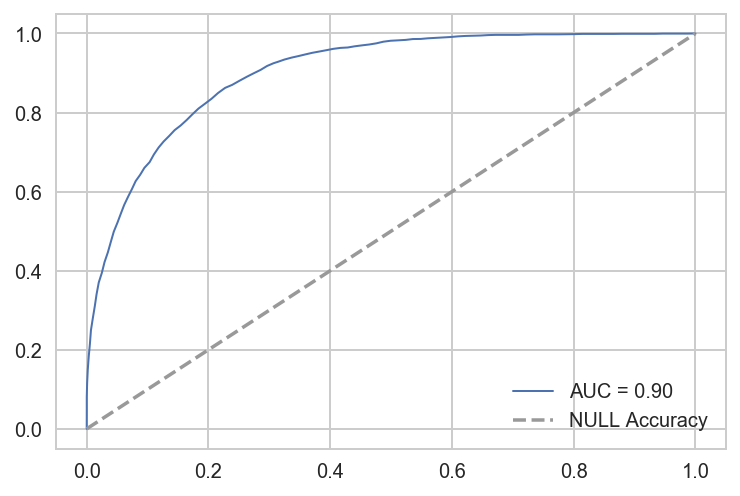

In [106]:
plt.figure(figsize=(6,4))
plt.plot(pdf['FPR'], pdf['TPR'], lw=1, label='AUC = %0.2f' % (test_summary.areaUnderROC))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.legend();

In [107]:
spark.stop()